# Linear Regression

In [176]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy import stats
import numpy as np

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

## Target Variable Distribution

In [177]:
df = pd.read_csv('../data/processed_data.csv')
dependent_variable = 'diff_percent'

feature_df = df.drop(columns=[dependent_variable])
target_df = df[dependent_variable]

feature_df.isna().sum()
feature_df.isnull().sum()

additional_paid_in_capital_trend     0
additional_paid_in_capital_recent    0
total_assets_trend                   0
total_assets_recent                  0
total_current_liabilities_trend      0
total_current_liabilities_recent     0
total_liabilities_trend              0
total_liabilities_recent             0
cash_trend                           0
cash_recent                          0
total_capitalization_trend           0
total_capitalization_recent          0
total_current_assets_trend           0
total_current_assets_recent          0
technology                           0
software                             0
ai                                   0
machine learning                     0
cloud                                0
saas                                 0
platform                             0
digital                              0
data                                 0
analytics                            0
algorithm                            0
automation               

In [178]:
## Data has heavy tails, but rather normally distributed without those tails. Will cap off the tails at the quantiles. Normal transformation will not work because the data is has negative values and

from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal', random_state=42)
target_df_transformed = qt.fit_transform(target_df.to_frame()).flatten()
stat, p_val = stats.shapiro(target_df_transformed)
print(f"Quantile Transform: {stat:.4f}, p-value: {p_val:.2e}")


Quantile Transform: 0.9972, p-value: 1.41e-03


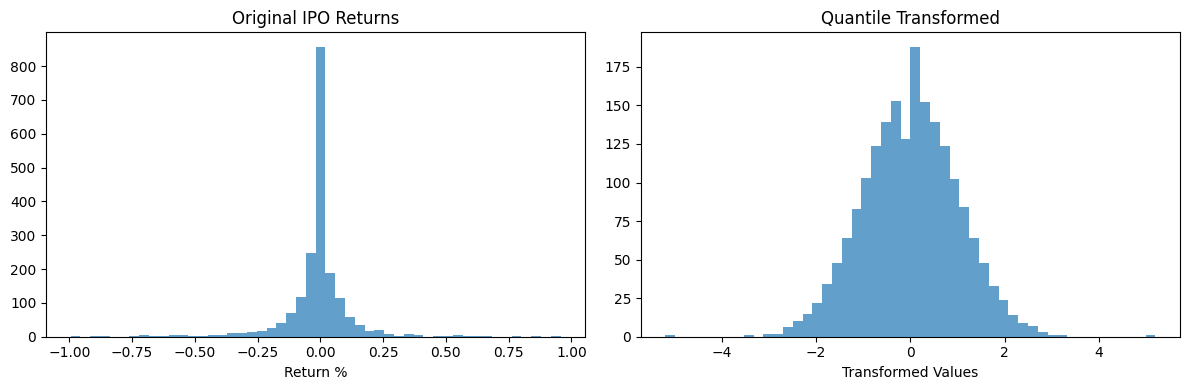

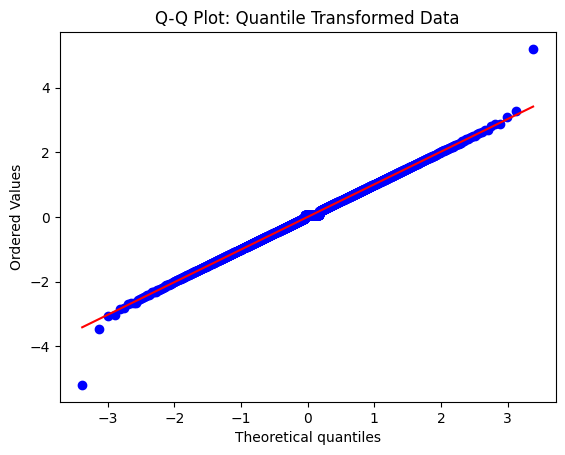

In [179]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Original data
ax1.hist(df['diff_percent'], bins=50, alpha=0.7)
ax1.set_title('Original IPO Returns')
ax1.set_xlabel('Return %')

# Transformed data
ax2.hist(target_df_transformed, bins=50, alpha=0.7)
ax2.set_title('Quantile Transformed')
ax2.set_xlabel('Transformed Values')

plt.tight_layout()
plt.show()

# Q-Q plot to check normality visually
import scipy.stats as stats
stats.probplot(target_df_transformed, dist="norm", plot=plt)
plt.title("Q-Q Plot: Quantile Transformed Data")
plt.show()

In [180]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
feature_df_train, feature_df_test, target_df_train, target_df_test = train_test_split(feature_df, target_df, test_size=0.2, random_state=42)

## Apply StandardScalar to feature set
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
feature_df_train_scaled = scaler.fit_transform(feature_df_train)
feature_df_test_scaled = scaler.transform(feature_df_test)


## Apply Quantile Transformation to target variable
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal', random_state=42)
target_df_train_transformed = qt.fit_transform(target_df_train.to_frame()).flatten()

target_df_train_transformed.shape

(1543,)

In [181]:
from sklearn.metrics import mean_squared_error, r2_score

## Training
lr = LinearRegression()
lr.fit(feature_df_train_scaled, target_df_train_transformed)

target_prediction_transformed = lr.predict(feature_df_test_scaled)
target_prediction = qt.inverse_transform(target_prediction_transformed.reshape(-1, 1))

mse = mean_squared_error(target_df_test, target_prediction)
r2 = r2_score(target_df_test, target_prediction)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")


Mean Squared Error: 0.0308
R^2 Score: -0.3764


/Users/jkarrer/devjon/ipo-case-study/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


In [182]:
# See which features the model thinks are important
# Convert back to DataFrame with original column names
feature_df_train_scaled = pd.DataFrame(
    feature_df_train_scaled, 
    columns=feature_df_train.columns,
    index=feature_df_train.index
)

# Now this will work
feature_importance = pd.DataFrame({
    'feature': feature_df_train_scaled.columns,
    'coefficient': lr.coef_.flatten()
})
print(feature_importance.head())

                             feature  coefficient
0   additional_paid_in_capital_trend     0.077790
1  additional_paid_in_capital_recent     0.089478
2                 total_assets_trend     0.069320
3                total_assets_recent     0.024914
4    total_current_liabilities_trend    -0.129974


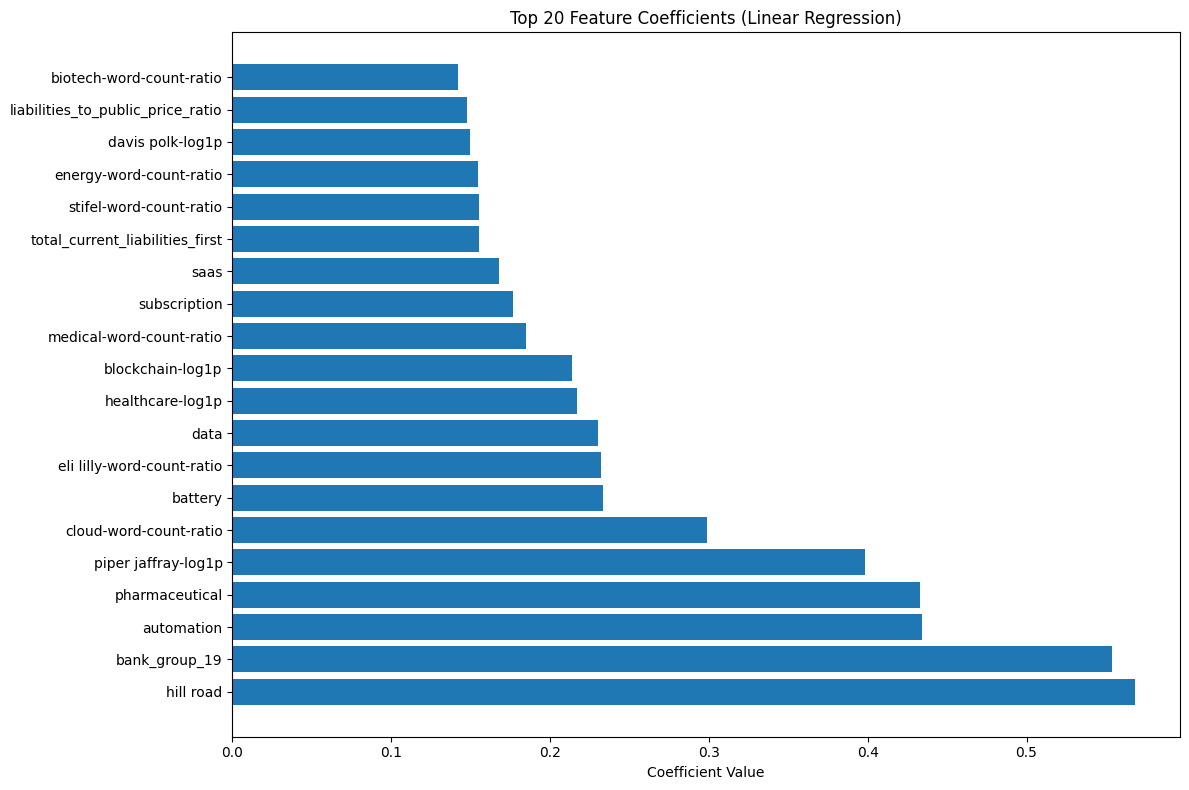

Highly correlated feature pairs (>0.8):
additional_paid_in_capital_trend <-> additional_paid_in_capital_recent: 0.952
additional_paid_in_capital_trend <-> total_current_assets_trend: 0.835
additional_paid_in_capital_recent <-> total_current_assets_trend: 0.804
total_assets_trend <-> total_assets_recent: 0.969
total_assets_trend <-> total_liabilities_trend: 0.934
total_assets_trend <-> total_liabilities_recent: 0.937
total_assets_trend <-> total_assets_first: 0.837
total_assets_trend <-> assets_to_public_price_ratio: 0.894
total_assets_trend <-> liabilities_to_public_price_ratio: 0.895
total_assets_recent <-> total_liabilities_trend: 0.924
total_assets_recent <-> total_liabilities_recent: 0.971
total_assets_recent <-> total_assets_first: 0.947
total_assets_recent <-> total_liabilities_first: 0.901
total_assets_recent <-> assets_to_public_price_ratio: 0.871
total_assets_recent <-> liabilities_to_public_price_ratio: 0.875
total_current_liabilities_trend <-> total_current_liabilities_recen

In [183]:
# 1. Visualize feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
top_20 = feature_importance.sort_values('coefficient', ascending=False).head(20)
plt.barh(range(len(top_20)), top_20['coefficient'])
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Feature Coefficients (Linear Regression)')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Check for multicollinearity
correlation_matrix = feature_df_train.corr()
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

print("Highly correlated feature pairs (>0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} <-> {pair[1]}: {pair[2]:.3f}")


In [184]:
# Remove highly correlated features
def remove_highly_correlated_features(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(
        np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    )
    
    # Find features to drop
    to_drop = [column for column in upper_triangle.columns 
               if any(upper_triangle[column] > threshold)]
    
    return df.drop(columns=to_drop), to_drop

# Apply correlation filtering
feature_df_train_filtered, dropped_features = remove_highly_correlated_features(
    feature_df_train, threshold=0.8
)
feature_df_test_filtered = feature_df_test.drop(columns=dropped_features)

print(f"Dropped {len(dropped_features)} highly correlated features")
print(f"Remaining features: {len(feature_df_train_filtered.columns)}")

Dropped 126 highly correlated features
Remaining features: 138


In [185]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
# Keep as DataFrames throughout
scaler = StandardScaler()
feature_df_train_filtered_scaled = pd.DataFrame(
    scaler.fit_transform(feature_df_train_filtered),
    columns=feature_df_train_filtered.columns,
    index=feature_df_train_filtered.index
)

feature_df_test_filtered_scaled = pd.DataFrame(
    scaler.transform(feature_df_test_filtered),
    columns=feature_df_test_filtered.columns,
    index=feature_df_test_filtered.index
)

gb = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

gb.fit(feature_df_train_filtered_scaled, target_df_train_transformed.flatten())

gb_pred_transformed = gb.predict(feature_df_test_filtered_scaled)
gb_pred = qt.inverse_transform(gb_pred_transformed.reshape(-1, 1))
gb_r2 = r2_score(target_df_test, gb_pred)

print(f"Gradient Boosting R²: {gb_r2:.4f}")

Gradient Boosting R²: -0.0095


/Users/jkarrer/devjon/ipo-case-study/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


In [186]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
# Keep as DataFrames throughout
scaler = StandardScaler()
feature_df_train_filtered_scaled = pd.DataFrame(
    scaler.fit_transform(feature_df_train_filtered),
    columns=feature_df_train_filtered.columns,
    index=feature_df_train_filtered.index
)

feature_df_test_filtered_scaled = pd.DataFrame(
    scaler.transform(feature_df_test_filtered),
    columns=feature_df_test_filtered.columns,
    index=feature_df_test_filtered.index
)

# Rest of your code stays the same
lr = LinearRegression()
lr.fit(feature_df_train_filtered_scaled, target_df_train_transformed)

target_prediction_transformed = lr.predict(feature_df_test_filtered_scaled)
target_prediction = qt.inverse_transform(target_prediction_transformed.reshape(-1, 1))

mse = mean_squared_error(target_df_test, target_prediction)
r2 = r2_score(target_df_test, target_prediction)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

Mean Squared Error: 0.0294
R^2 Score: -0.3111


/Users/jkarrer/devjon/ipo-case-study/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


In [187]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

# Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(feature_df_train_filtered_scaled, target_df_train_transformed.flatten())

rf_pred_transformed = rf.predict(feature_df_test_filtered_scaled)
rf_pred = qt.inverse_transform(rf_pred_transformed.reshape(-1, 1))
rf_r2 = r2_score(target_df_test, rf_pred)

print(f"Random Forest R²: {rf_r2:.4f}")

Random Forest R²: 0.0010


/Users/jkarrer/devjon/ipo-case-study/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


In [188]:
# Get feature importance from the RF model
rf_importance = pd.DataFrame({
    'feature': feature_df_train_filtered.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features (Random Forest):")
print(rf_importance.head(15))

# Try using only top RF features
top_rf_features = rf_importance.head(20)['feature'].tolist()


Top 15 Most Important Features (Random Forest):
                              feature  importance
46                 price_public_total    0.082288
119                          ipo_year    0.062463
3                          cash_trend    0.039948
113          asset_to_liability_ratio    0.035920
0    additional_paid_in_capital_trend    0.033626
104  additional_paid_in_capital_first    0.033063
117                           ipo_day    0.027485
2     total_current_liabilities_trend    0.026628
63                    document_length    0.025772
36                            battery    0.024245
73               unique_keyword_count    0.023821
98                      battery-log1p    0.021256
6                          technology    0.021202
112       total_current_assets_change    0.020743
74                   technology-log1p    0.020576


In [189]:
# Use top 20 features identified by Random Forest
X_train_top_rf = feature_df_train_filtered[top_rf_features]
X_test_top_rf = feature_df_test_filtered[top_rf_features]

# Scale
X_train_top_rf_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_top_rf),
    columns=X_train_top_rf.columns
)
X_test_top_rf_scaled = pd.DataFrame(
    scaler.transform(X_test_top_rf),
    columns=X_test_top_rf.columns
)

# Train RF on top features only
rf_top = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_top.fit(X_train_top_rf_scaled, target_df_train_transformed.flatten())

rf_top_pred_transformed = rf_top.predict(X_test_top_rf_scaled)
rf_top_pred = qt.inverse_transform(rf_top_pred_transformed.reshape(-1, 1))
rf_top_r2 = r2_score(target_df_test, rf_top_pred)

print(f"Random Forest (Top 20 features) R²: {rf_top_r2:.4f}")


Random Forest (Top 20 features) R²: 0.0015


/Users/jkarrer/devjon/ipo-case-study/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
